# **Capitulo 4: Introducción a Métodos Autorregresivos y Automatizados para el Pronóstico de Series de Tiempo**

La elaboración de pronósticos es una parte integral de cualquier negocio, ya sea en relación con los ingresos, el inventario, las ventas en línea o la previsión de la demanda de los clientes. La previsión de series de tiempo sigue siendo fundamental porque en el mundo real existen varios problemas y datos relacionados que presentan una dimensión temporal.

Aplicar modelos de aprendizaje automático para acelerar los pronósticos permite la escalabilidad, el rendimiento y la precisión de soluciones inteligentes que pueden mejorar las operaciones comerciales. Sin embargo, la construcción de modelos de aprendizaje automático suele ser consumidora de tiempo y compleja, con muchos factores a considerar, como la iteración a través de algoritmos, la ajuste de hiperparámetros de aprendizaje automático y la aplicación de técnicas de ingeniería de características. Estas opciones se multiplican cuando se trabaja con datos de series de tiempo, ya que los científicos de datos deben tener en cuenta factores adicionales, como las tendencias, la estacionalidad, las festividades y las variables económicas externas.

## **Autoregresión**

Es un método de pronóstico de series de tiempo que depende únicamente de las salidas anteriores de una serie de tiempo. Esta técnica asume que las futuras observaciones en el próximo período de tiempo están relacionadas con las observaciones en períodos anteriores a través de una relación lineal.

En este método, el valor de salida en el período de tiempo anterior se convierte en el valor de entrada para predecir el valor del próximo período de tiempo, y los errores siguen las suposiciones habituales sobre los errores en un modelo de regresión lineal simple. En las autoregresiones, el número de valores de entrada anteriores en la serie de tiempo que se utilizan para predecir el valor del próximo período de tiempo se llama *orden* (a menudo nos referimos al orden con la letra $p$), que determina cuantos puntos de datos anteriores se utilizarán.

El valor de prediccióna actual (salida/output) se basa en el valor inmediatamente anterior (entrada/input) como autoregresión de primer orden, como se ilustra en la Figura 4.1

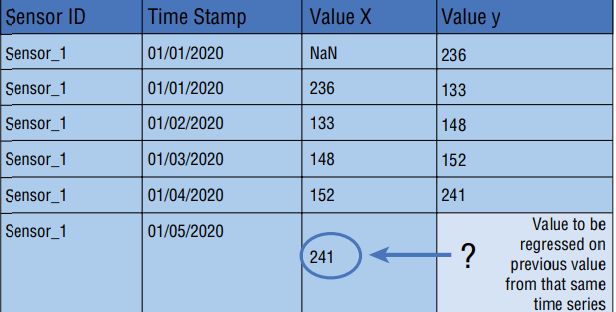

**Figura 4.1:** Enfoque de autoregresión de primer orden.

Para predecir el valor del próximo período de tiempo utilizando los dos valores anteriores en lugar de uno, entonces el enfoque se llama autoregresión de segundo orden.

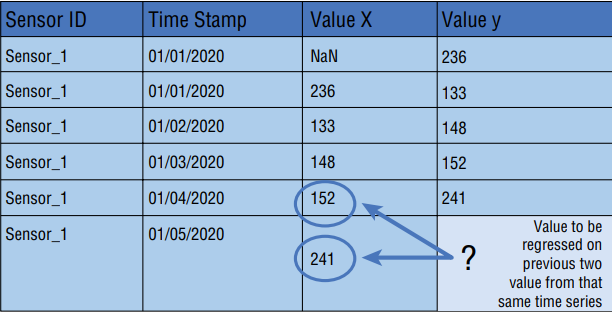

**Figura 4.2:** Enfoque de autoregresión de segundo orden.

De forma general, una autoregresión de orden $n$ es una regresión lineal múltiple en la que el valor de la serie en cualquier momento $t$ es una función lineal de los valores previos en esa misma serie de tiempo. Debido a esta dependencia secuencial, otro aspecto importante de las autoregresiones es la **autocorrelación**, que ocurre cuando una serie de tiempo está relacioanda linealmente con una versión previa o rezagada de sí misma. Entre mayor sea la correlación entre la salida (lo que se necesita predecir) y una variable específica (valores de entrada), mas péso puede poner la autoregresión en esa variable específica.

Algunos métodos de regresión, como la regresión lineal y la regresión de mínimos cuadrados ordinarios, se basan en la suposición implícita de que no hay presencia de autocorrelación en el conjunto de datos de entrenamiento utilizado para alimentar el modelo. Estos métodos se definen como metodologías paramétricas, ya que el conjunto de datos utilizado con ellos presenta una distribución normal y su función de regresión se define en términos de un número finito de parámetros desconocidos que se estiman a partir de los datos. Es por ello que la autocorrelación puede ayudar a seleccionar el método más adecuado para sus soluciones de pronóstico de series de tiempo; también, puede ser muy útil para obtener información adicional de los datos y entre sus variables, y para identificar patrones ocultos, como la estacionalidad y la tendencia en los datos de series de tiempo. 

Para verificar si existe autocorrelación en datos de series de tiempo, se puede utilizar dos gráficos incorporados proporcionados por pandas, llamados `lag_plot` y `autocorrelation_plot`. Estas funciones se pueden importar desde pandas.plotting y toman una Serie o un DataFrame como argumento. Ambos gráficos son verificaciones visuales que puede utilizar para ver si hay autocorrelación en su conjunto de datos de series de tiempo.

**Tabla 4.1:** Referencia y descripción de la API pandas.plotting.lag_plot

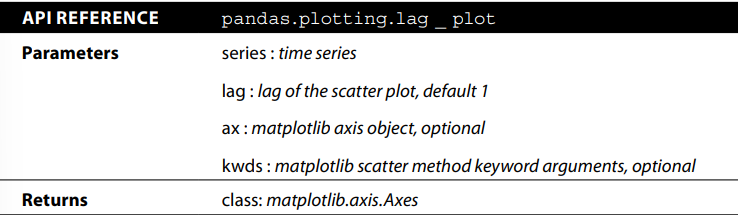

A continuación se muestra un ejemplo de cómo crear un gráfico de retraso para el conjunto ts_data_load. Primero, se importan las librerías necesarias y se cargan los datos en un DataFrame.


In [4]:
import zipfile
import os
import sys
import pandas as pd

# This function unzips the GEFCom2014 data zip file and extracts the 'extended'
# load forecasting competition data. Data is saved in energy.csv
def extract_data(data_dir):
    GEFCom_dir = os.path.join(data_dir, 'GEFCom2014', 'GEFCom2014 Data')

    GEFCom_zipfile = os.path.join(data_dir, 'GEFCom2014.zip')
    if not os.path.exists(GEFCom_zipfile):
        sys.exit("Download GEFCom2014.zip from https://www.dropbox.com/s/pqenrr2mcvl0hk9/GEFCom2014.zip?dl=0 and save it to the '{}' directory.".format(data_dir))

    # unzip root directory
    zip_ref = zipfile.ZipFile(GEFCom_zipfile, 'r')
    zip_ref.extractall(os.path.join(data_dir, 'GEFCom2014'))
    zip_ref.close()

    # extract the extended competition data
    zip_ref = zipfile.ZipFile(os.path.join(GEFCom_dir, 'GEFCom2014-E_V2.zip'), 'r')
    zip_ref.extractall(os.path.join(data_dir, 'GEFCom2014-E'))
    zip_ref.close()

    # load the data from Excel file
    data = pd.read_excel(os.path.join(data_dir, 'GEFCom2014-E', 'GEFCom2014-E.xlsx'), parse_dates= True)
    # data = pd.read_excel(os.path.join(data_dir, 'GEFCom2014-E', 'GEFCom2014-E.xlsx'), parse_date='Date')

    # create timestamp variable from Date and Hour
    data['timestamp'] = data['Date'].add(pd.to_timedelta(data.Hour - 1, unit='h'))
    data = data[['timestamp', 'load', 'T']]
    data = data.rename(columns={'T':'temp'})

    # remove time period with no load data
    data = data[data.timestamp >= '2012-01-01']

    # save to csv
    data.to_csv(os.path.join(data_dir, 'energy.csv'), index=False)

import numpy as np
import pandas as pd
import os
from collections import UserDict

def load_data(data_dir):
    """Load the GEFCom 2014 energy load data"""

    energy = pd.read_csv(os.path.join(data_dir, 'energy.csv'), parse_dates=['timestamp'])

    # Reindex the dataframe such that the dataframe has a record for every time point
    # between the minimum and maximum timestamp in the time series. This helps to 
    # identify missing time periods in the data (there are none in this dataset).

    energy.index = energy['timestamp']
    energy = energy.reindex(pd.date_range(min(energy['timestamp']),
                                          max(energy['timestamp']),
                                          freq='H'))
    energy = energy.drop('timestamp', axis=1)

    return energy


def mape(predictions, actuals):
    """Mean absolute percentage error"""
    return ((predictions - actuals).abs() / actuals).mean()


def create_evaluation_df(predictions, test_inputs, H, scaler):
    """Create a data frame for easy evaluation"""
    eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, H+1)])
    eval_df['timestamp'] = test_inputs.dataframe.index
    eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
    eval_df['actual'] = np.transpose(test_inputs['target']).ravel()
    eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
    return eval_df


class TimeSeriesTensor(UserDict):
    """A dictionary of tensors for input into the RNN model.
    
    Use this class to:
      1. Shift the values of the time series to create a Pandas dataframe containing all the data
         for a single training example
      2. Discard any samples with missing values
      3. Transform this Pandas dataframe into a numpy array of shape 
         (samples, time steps, features) for input into Keras

    The class takes the following parameters:
       - **dataset**: original time series
       - **target** name of the target column
       - **H**: the forecast horizon
       - **tensor_structures**: a dictionary discribing the tensor structure of the form
             { 'tensor_name' : (range(max_backward_shift, max_forward_shift), [feature, feature, ...] ) }
             if features are non-sequential and should not be shifted, use the form
             { 'tensor_name' : (None, [feature, feature, ...])}
       - **freq**: time series frequency (default 'H' - hourly)
       - **drop_incomplete**: (Boolean) whether to drop incomplete samples (default True)
    """
    
    def __init__(self, dataset, target, H, tensor_structure, freq='H', drop_incomplete=True):
        self.dataset = dataset
        self.target = target
        self.tensor_structure = tensor_structure
        self.tensor_names = list(tensor_structure.keys())
        
        self.dataframe = self._shift_data(H, freq, drop_incomplete)
        self.data = self._df2tensors(self.dataframe)
    
    def _shift_data(self, H, freq, drop_incomplete):
        
        # Use the tensor_structures definitions to shift the features in the original dataset.
        # The result is a Pandas dataframe with multi-index columns in the hierarchy
        #     tensor - the name of the input tensor
        #     feature - the input feature to be shifted
        #     time step - the time step for the RNN in which the data is input. These labels
        #         are centred on time t. the forecast creation time
        df = self.dataset.copy()
        
        idx_tuples = []
        for t in range(1, H+1):
            df['t+'+str(t)] = df[self.target].shift(t*-1, freq=freq)
            idx_tuples.append(('target', 'y', 't+'+str(t)))

        for name, structure in self.tensor_structure.items():
            rng = structure[0]
            dataset_cols = structure[1]
            
            for col in dataset_cols:
            
            # do not shift non-sequential 'static' features
                if rng is None:
                    df['context_'+col] = df[col]
                    idx_tuples.append((name, col, 'static'))

                else:
                    for t in rng:
                        sign = '+' if t > 0 else ''
                        shift = str(t) if t != 0 else ''
                        period = 't'+sign+shift
                        shifted_col = name+'_'+col+'_'+period
                        df[shifted_col] = df[col].shift(t*-1, freq=freq)
                        idx_tuples.append((name, col, period))
                
        df = df.drop(self.dataset.columns, axis=1)
        idx = pd.MultiIndex.from_tuples(idx_tuples, names=['tensor', 'feature', 'time step'])
        df.columns = idx

        if drop_incomplete:
            df = df.dropna(how='any')

        return df
    
    def _df2tensors(self, dataframe):
        
        # Transform the shifted Pandas dataframe into the multidimensional numpy arrays. These
        # arrays can be used to input into the keras model and can be accessed by tensor name.
        # For example, for a TimeSeriesTensor object named "model_inputs" and a tensor named
        # "target", the input tensor can be acccessed with model_inputs['target']
    
        inputs = {}
        y = dataframe['target']
        y = y.as_matrix()
        inputs['target'] = y

        for name, structure in self.tensor_structure.items():
            rng = structure[0]
            cols = structure[1]
            tensor = dataframe[name][cols].as_matrix()
            if rng is None:
                tensor = tensor.reshape(tensor.shape[0], len(cols))
            else:
                tensor = tensor.reshape(tensor.shape[0], len(cols), len(rng))
                tensor = np.transpose(tensor, axes=[0, 2, 1])
            inputs[name] = tensor

        return inputs
       
    def subset_data(self, new_dataframe):
        
        # Use this function to recreate the input tensors if the shifted dataframe
        # has been filtered.
        
        self.dataframe = new_dataframe
        self.data = self._df2tensors(self.dataframe)

In [5]:
# download ts_data set
# change the name of the directory with your folder name
data_dir = './energy'
if not os.path.exists(os.path.join(data_dir, 'energy.csv')):
 # download and move the zip file
 !wget https://mlftsfwp.blob.core.windows.net/mlftsfwp/GEFCom2014.zip
 !mv GEFCom2014.zip ./energy
 # if not done already, extract zipped data and save as csv
 extract_data(data_dir)

In [6]:
# Import necessary libraries
import datetime as dt
import os
import warnings
from collections import UserDict
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Image
%matplotlib inline
pd.options.display.float_format = "{:,.2f}".format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")
# Load the data from csv into a pandas dataframe
ts_data_load = load_data(data_dir)[['load']]

,load
2012-01-01 00:00:00,"2,698.00"
2012-01-01 01:00:00,"2,558.00"
2012-01-01 02:00:00,"2,444.00"
2012-01-01 03:00:00,"2,402.00"
2012-01-01 04:00:00,"2,403.00"


Ahora, creamos un gráfico de retraso para el conjunto ts_data_load, seleccionando solo la carga columna:

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

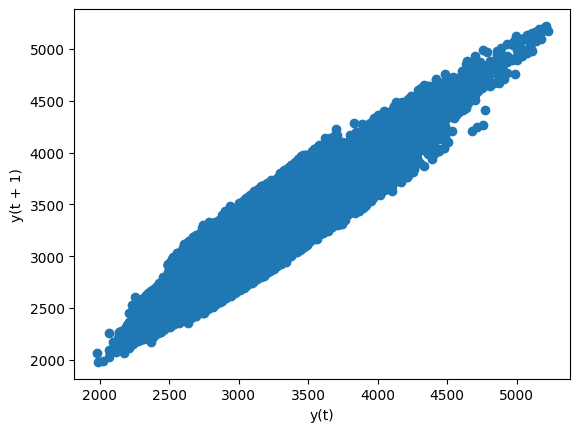

In [7]:
# Import lag_plot function
from pandas.plotting import lag_plot
plt.figure()
# Pass the lag argument and plot the values.
# When lag=1 the plot is essentially data[:-1] vs. data[1:]
# Plot our ts_data_load set
lag_plot(ts_data_load)

Esos gráficos de retardo de utilizan para comprobar que un conjunto de datos o una serie de tiempo es aleatorio. En la gráfica anterior se puede ver una línea diagonal, lo cuál muestra una relación o cierta correlación entre esas observaciones.

**Tabla 4.2:** Referencia y descripción de la API pandas.plotting.lag_plot 

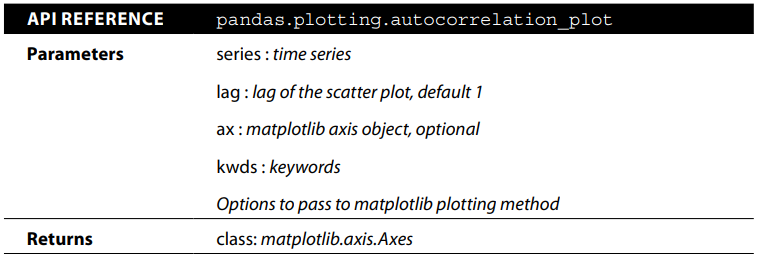

Los gráficos de autocorrelación son utilizados para verificar la aleatoriedad en las series de tiempo mediante el cálculo de las autocorrelaciones de los valores de datos en retrasos de tiempo fluctuantes. Si la serie de tiempo es aleatoria, los valores de autocorrelación deberían estar cerca de cero para todos los retrasos de tiempo. Si la serie de tiempo no es aleatoria, entonces uno o más de los valores de autocorrelación serán significativamente distintos de cero.

Se muestra un ejemplo de cómo crear un gráfico de autocorrelación para el conjunto de datos de series de tiempo llamado "ts_data_load".

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

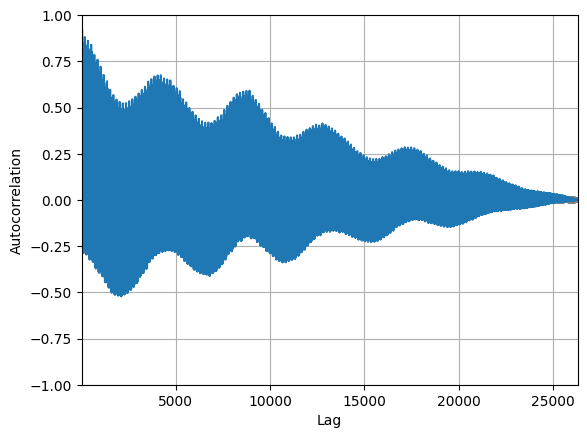

In [8]:
# Import autocorrelation_plot function
from pandas.plotting import autocorrelation_plot
plt.figure()
# Pass the autocorrelation argument and plot the values
autocorrelation_plot(ts_data_load)

Por la cantidad de datos que se tienen en ts_data_load, se selecciona un subconjunto de datos para ver las líneas horizontaes que deberían aparecer en el gráfico de autocorrelación y se aplica nuevamente la función.

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

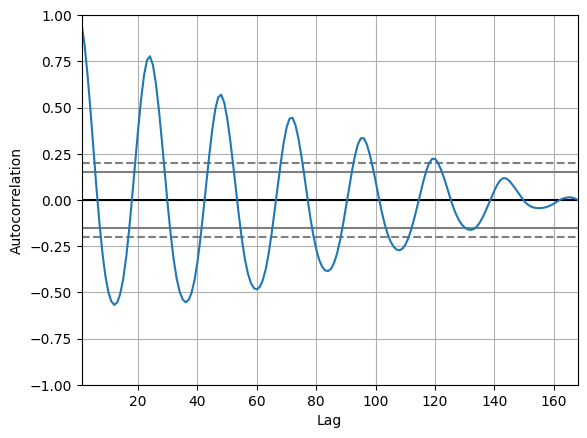

In [9]:
# Create subset
ts_data_load_subset = ts_data_load['2014-08-01':'2014-08-07']
# Import autocorrelation _plot function
from pandas.plotting import autocorrelation_plot
plt.figure()
# Pass the autocorrelation argument and plot the values
autocorrelation_plot(ts_data_load_subset)

El gráfico de autocorrelación muestra el valor de la función de autocorrelación en el eje vertical, que puede variar de -1 a 1.  Las líneas horizontales mostradas en el gráfico corresponden a bandas de confianza del 95% y del 99%, y la línea punteada es la banda de confianza del 99 por ciento. El gráfico de autocorrelación tiene como objetivo revelar si los puntos de datos de una serie de tiempo están positivamente correlacionados, negativamente correlacionados o son independientes entre sí.

Un gráfico de la autocorrelación de una serie de tiempo en función del retraso también se llama función de autocorrelación (ACF). Python admite la ACF con la función `plot_acf()` de la biblioteca statsmodels. A continuación, se muestra un ejemplo de cómo calcular y graficar el gráfico de autocorrelación para el conjunto de datos ts_data_load utilizando la función `plot_acf()`.

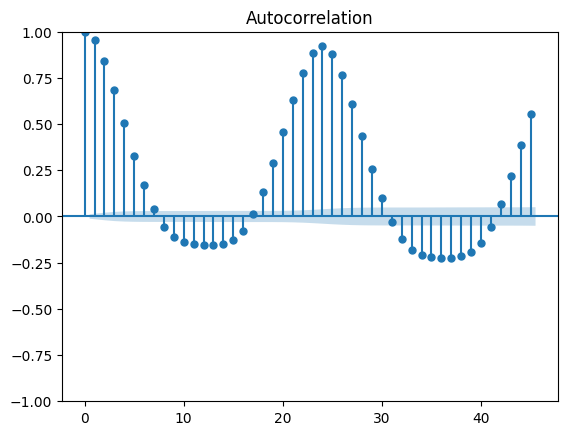

In [11]:
# Import plot_acf() function
from statsmodels.graphics.tsaplots import plot_acf
# Plot the acf function on the ts_data_load set
plot_acf(ts_data_load)
plt.show()

Ahora para el subconjunto de datos.

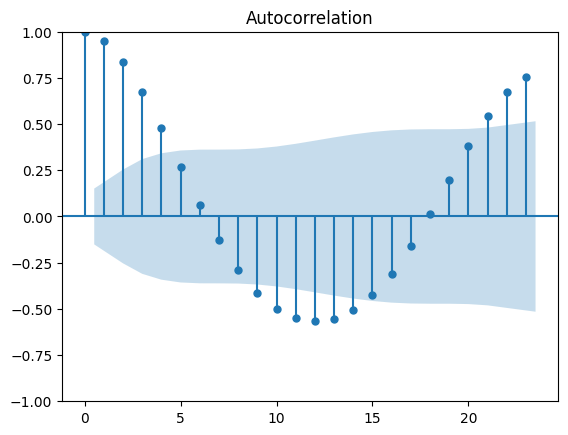

In [12]:
# Import plot_acf() function
from statsmodels.graphics.tsaplots import plot_acf
# Plot the acf function on the ts_data_load_subset
plot_acf(ts_data_load_subset)
plt.show()

Las ilustraciones anteriores muestran intervalos de confianza trazados en forma de cono. Por defecto, esto se establece en un intervalo de confianza del 95%, lo que sugiere que los valores de correlación fuera de este cono son muy probablemente una correlación.

Otro concepto importante a considerar es la función de correlación parcial (PACF), que es la correlación entre dos variables bajo la suposición de que consideramos los valores de algún otro conjunto de variables. En la regresión, esta correlación parcial se puede encontrar correlacionando los residuos de dos regresiones diferentes.

En un conjunto de datos de series de tiempo, la autocorrelación para un valor en un período de tiempo y otro valor en un período de tiempo anterior consiste tanto en la correlación directa entre estos dos valores como en correlaciones indirectas. Estas correlaciones indirectas son una función lineal de la correlación del valor bajo observación con los valores en períodos de tiempo intermedios.

Python admite la función PACF con `plot_pacf()`. El ejemplo a continuación calcula y grafica una función de autocorrelación parcial para los primeros 20 retrasos de los datos ts_data_load.

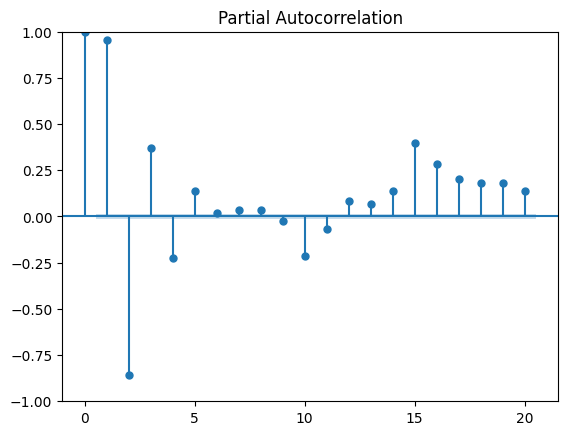

In [14]:
# Import plot_pacf() function
from statsmodels.graphics.tsaplots import plot_pacf
# Plot the pacf function on the ts_data_load dataset
plot_pacf(ts_data_load, lags=20)
plt.show()

Los conceptos y las respectivas gráficas de las funciones ACF y PACF se vuelven particularmente importantes cuando se necesita comprender y determinar el orden de los métodos de series de tiempo autorregresivas y de media móvil. Hay dos métodos que se pueden utilizar para identificar el orden de un modelo AR(p):

- Las funciones ACF y PACF
- Los criterios de información

Como se ilustra en el gráfico anterior, la ACF es una función de autocorrelación que proporciona información sobre cuánto una serie está autocorrelacionada con sus valores rezagados, es decir, cuán relacionado está el valor presente de la serie con sus valores pasados.

Por otro lado, la PACF es otra función importante que encuentra la correlación entre los residuos y el siguiente rezago. Mide el beneficio incremental de agregar otro rezago. Entonces, si a través de la función PACF se descubre que hay información oculta en los residuos que puede ser modelada por el siguiente rezago, se podría obtener una buena correlación y mantendrá ese próximo rezago como característica al modelar.

Para evitar características multicolineales en los modelos de series de tiempo, es necesario encontrar características óptimas u orden del proceso de autorregresión utilizando la gráfica PACF, ya que elimina las variaciones explicadas por rezagos anteriores, de modo que obtenemos solo las características relevantes. Observe que una buena correlación positiva con los rezagos hasta el rezago número 6; este es el punto en el que la gráfica de ACF corta el umbral de confianza superior. Aunque tenemos se tiene buena correlación hasta el sexto rezago, no se puede usar todos ellos, ya que crearía un problema de multicolinealidad; por eso se recurre a la gráfica PACF para obtener solo los rezagos más relevantes.

El siguiente ejemplo calcula y representa gráficamente una función de autocorrelación parcial para los primeros 30 retrasos del subconjunto de datos "ts_data_load".

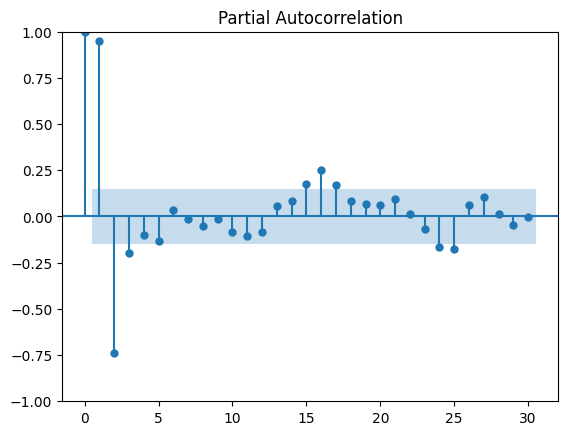

In [16]:
# plot the pacf function on the ts_data_load_subset
plot_pacf(ts_data_load_subset, lags=30)
plt.show()

En el gráfico anterior, los rezagos hasta 6 tienen buena correlación antes de que la gráfica corte por primera vez el intervalo de confianza superior. Este es el valor p, que es el orden del proceso de autorregresión. Se puede modelar el proceso de autorregresión dado utilizando una combinación lineal de los primeros 6 rezagos. También se puede ver que los rezagos hasta 1 tienen buena correlación antes de que la gráfica corte por primera vez el intervalo de confianza superior. Este es el valor p, el orden del proceso de autorregresión. Luego se puede modelar este proceso de autorregresión utilizando el primer rezago.

Cuanto más rezagos se incluyan en el modelo, mejor se ajustará el modelos; sin embargo, esto también puede representar un riesgo de sobreajuste. Los criterios de información ajustan la bondad del ajuste de un modelo imponiendo una penalización basada en el número de parámetros utilizados. Hay dos medidas populares de bondad de ajuste ajustadas:

- AIC
- BIC

Para obtener la información de estas dos medidas, se usa la función summary(), el atributo params o los atributos aic y bic en Python. 

**Tabla 4.3:** : Clase autorregresiva en statsmodels.

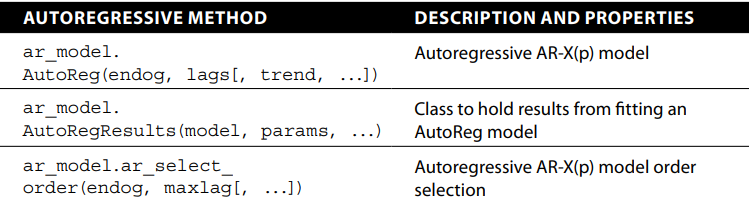

